In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, display, DataFrame, np)
import os
import pandas as pd
import matplotlib.pyplot as plt

In [16]:

if nu.pickle_exists('tag_to_salt_df'):
    tag_to_salt_df = nu.load_object('tag_to_salt_df')
    print(tag_to_salt_df.shape)
    df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(5762, 12)


,5757,3728,1220,5669
session_uuid,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,a1cb9dd5-e62b-4085-99d8-688e0a3856ee,30479d0b-79c8-4672-84c2-5bce9ec0972b,fd1c7057-2c2d-4dec-9297-92ef0621c15e
scene_id,5,1,1,1
patient_id,Helga_10 Root,Lily_4 Root,Lily_7 Root,Bob_0 Root
logger_version,1.3,1.0,1.3,1.3
is_scene_aborted,False,False,False,False
scene_type,Triage,Triage,Triage,Triage
is_a_one_triage_file,True,True,True,True
patient_count,1,1,1,1
last_tag,green,yellow,black,black
max_salt,MINIMAL,IMMEDIATE,DEAD,DEAD



# Triage Accuracy


We are measuring to what extent the responders over- or under-triaged the patients. The grey-scale visualizations are from _First Responder Accuracy Using SALT during Mass-casualty Incident Simulation_, original research by Christopher W.C. Lee, MD, BASc; Shelley L. McLeod, MSc, BSc Hons; Kristine Van Aarsen, MSc, BSc; Michelle Klingel, MSc, BSc; Jeffrey M. Franc, MD, MSc, FCFP(EM), Dip. Sport Med., EMDM; and Michael B. Peddle, MD, FRCP(C), Dip. Sport Med.


## Create the error table


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/error_table.png" />

In [5]:

fu.error_table_df

,DEAD,EXPECTANT,IMMEDIATE,MINIMAL,DELAYED
black,Exact,Critical,Critical,Critical,Critical
gray,Over,Exact,Critical,Critical,Critical
red,Over,Over,Exact,Over,Over
green,Over,Over,Under,Over,Exact
yellow,Over,Over,Under,Exact,Under



## Create the error type data frame

In [17]:

mask_series = (tag_to_salt_df.scene_type == 'Triage') & (tag_to_salt_df.is_scene_aborted == False)
mask_series &= (tag_to_salt_df.is_a_one_triage_file == True)
groupby_columns = ['last_tag', 'max_salt']
ERROR_TYPE_DF = tag_to_salt_df[mask_series].groupby(groupby_columns).patient_count.sum().to_frame()
f = lambda df: fu.error_table_df[fu.error_table_df.index == df.name[0]][df.name[1]].squeeze()
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF.apply(f, axis='columns')
ERROR_TYPE_DF = ERROR_TYPE_DF.reset_index()

# Convert the columns to the custom categorical type
ERROR_TYPE_DF['last_tag'] = ERROR_TYPE_DF['last_tag'].astype(fu.colors_category_order)
ERROR_TYPE_DF['max_salt'] = ERROR_TYPE_DF['max_salt'].astype(fu.salt_category_order)
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF['error_type'].astype(fu.errors_category_order)

# Sort the Data Frame based on the custom categorical orders
ERROR_TYPE_DF = ERROR_TYPE_DF.sort_values(by=groupby_columns+['error_type'])

In [18]:

print(ERROR_TYPE_DF.shape)
ERROR_TYPE_DF

(21, 4)


,last_tag,max_salt,patient_count,error_type
0,black,DEAD,347,Exact
1,black,EXPECTANT,62,Critical
2,black,IMMEDIATE,3,Critical
3,gray,DEAD,7,Over
5,gray,EXPECTANT,219,Exact
6,gray,IMMEDIATE,43,Critical
7,gray,MINIMAL,4,Critical
4,gray,DELAYED,3,Critical
12,red,DEAD,2,Over
14,red,EXPECTANT,30,Over


In [19]:

import matplotlib.colors as mcolors
# import random

color_substrings = fu.tag_colors + ['grey']
# error_colors = random.sample(
#     [color_name for color_name in mcolors.CSS4_COLORS.keys() if not any(map(lambda x: (x in color_name), color_substrings))],
#     len(fu.error_values)
# )
error_colors = ['plum', 'fuchsia', 'tan', 'pink']
LABELS_DICT = {k: v for k, v in zip(fu.error_values, error_colors)}
suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)

idx = color_substrings.index('gray')
color_substrings.pop(idx); color_substrings.pop(color_substrings.index('grey')); color_substrings.insert(idx, 'gray/grey')
print(
    f"""
Patients are logged with a SALT category ({nu.conjunctify_nouns(fu.patient_salt_order, and_or='or')}) as"""
    f""" soon as they arrive on the scene. The responder will eventually tag ({nu.conjunctify_nouns(fu.tag_colors, and_or='or')})"""
    """ each patient zero, one, or even multiple times (so we take the last one logged). For each tagged patient, we are able to"""
    """ compute triage errors, if any.

The triage errors are visualized using consistent colors. The colors are a random assortment of CSS4 colors whose names don't have"""
    f""" the tag colors ({nu.conjunctify_nouns(color_substrings, and_or='or')}) as substrings in them. For now I have settled"""
    f""" on {nu.conjunctify_nouns([f'{v} for {suffixing_fn(k)}' for k, v in LABELS_DICT.items()])} because they grayscale nicely"""
    """ and I like to think of pink as under-done. :-)
""")


Patients are logged with a SALT category (DEAD, EXPECTANT, IMMEDIATE, MINIMAL, or DELAYED) as soon as they arrive on the scene. The responder will eventually tag (black, gray, red, green, or yellow) each patient zero, one, or even multiple times (so we take the last one logged). For each tagged patient, we are able to compute triage errors, if any.

The triage errors are visualized using consistent colors. The colors are a random assortment of CSS4 colors whose names don't have the tag colors (black, gray/grey, red, green, or yellow) as substrings in them. For now I have settled on plum for Exact, fuchsia for Critical Error, tan for Over-triage Error, and pink for Under-triage Error because they grayscale nicely and I like to think of pink as under-done. :-)




## Display some vertical bar charts


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_triage_accuracy.png" />


Figure 3 looks like a box plot graph with one hair. I think it's just showing how much lower it is than the left bar. It does have percent change and confidence interval notation on top that would lead you to believe it's a statistically significant 7.9% change.

In [14]:

def show_vertical_bar_chart(column_name, title):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    
    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    
    # Create data for each group
    data_list = []
    labels_list = ['']
    for i, column_value in enumerate(unique_categories):
        labels_list.append(column_value)
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').count().reset_index()
        total_patient_count = df.patient_count.sum()
        mask_series = (df.error_type == 'Exact')
        accuracy_patient_count = df[mask_series].patient_count.sum()
        accuracy_patient_percent = 100*accuracy_patient_count/total_patient_count
        data_list.append(accuracy_patient_percent)
    
    # Create a bar chart
    ax.bar(range(len(data_list)), data_list, color=fu.tag_colors)
    
    # Humanize x tick labels
    ax.set_xticklabels(labels_list)
    
    # Set the title, labels, and grid
    ax.set_title(title)
    ax.set_ylabel('Percent Accurate (%)')
    plt.grid(False)
    
    # Show the plot
    plt.show()


### Vertical bar charts grouped by the patient record SALT

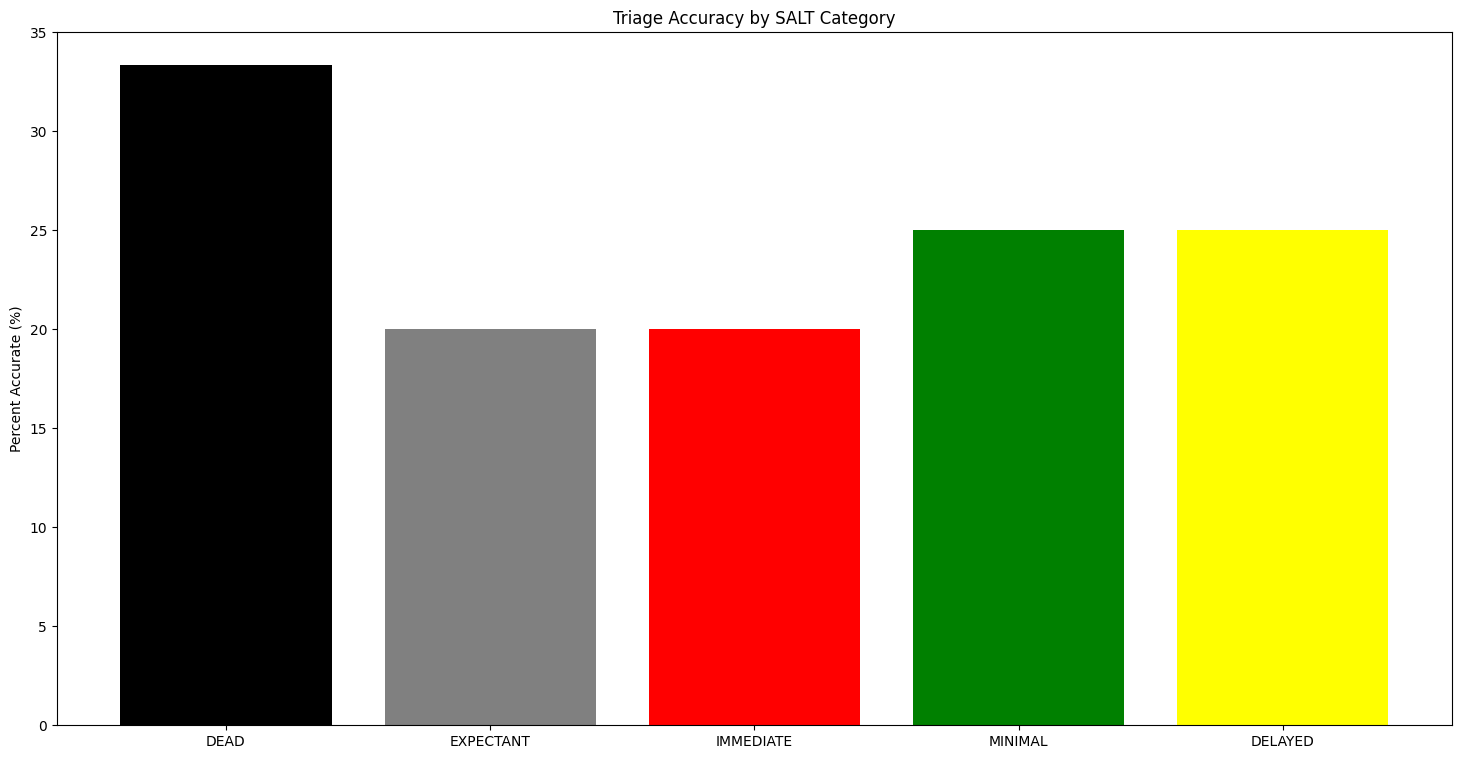

In [20]:

show_vertical_bar_chart('max_salt', 'Triage Accuracy by SALT Category')


### Vertical bar charts grouped by the last time the patient was tagged


layout: dcen data, deleware county, 11 patients

triage time is scene end - scene start

time to last triage control defaults to end of sim

wound packs and tourniquets per scene

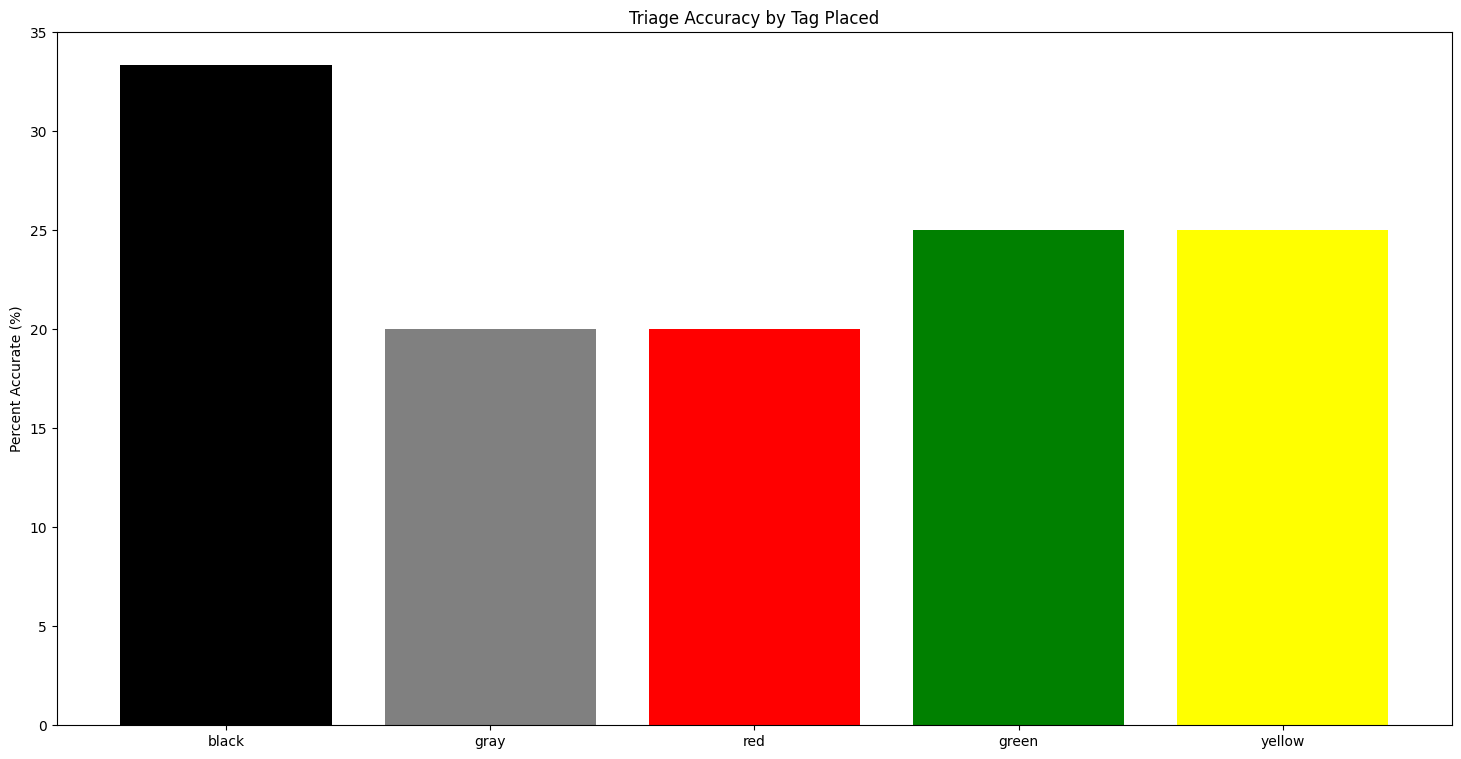

In [21]:

show_vertical_bar_chart('last_tag', 'Triage Accuracy by Tag Placed')


## Display some stacked horizontal bar charts


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_triage_errors.png" />

In [20]:

def show_stacked_horizontal_bar_chart(column_name, ylabel=''):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    over_values, under_values, critical_values = [], [], []
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        total_patient_count = df.patient_count.sum()
        error_dict = df.set_index('error_type').patient_count.to_dict()
        
        over_patient_count = error_dict.get('Over', 0)
        over_values.append(100*over_patient_count/total_patient_count)
        
        under_patient_count = error_dict.get('Under', 0)
        under_values.append(100*under_patient_count/total_patient_count)
        
        critical_patient_count = error_dict.get('Critical', 0)
        critical_values.append(100*critical_patient_count/total_patient_count)
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(unique_categories, over_values, color='tan', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(unique_categories, under_values, color='pink', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    critical_bar = plt.barh(
        unique_categories, critical_values, color='fuchsia', label=suffixing_fn('Critical'), left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center', color='black', fontsize=8
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    
    # Display the chart
    plt.show()


### Stacked horizontal bar charts grouped by the patient record SALT 

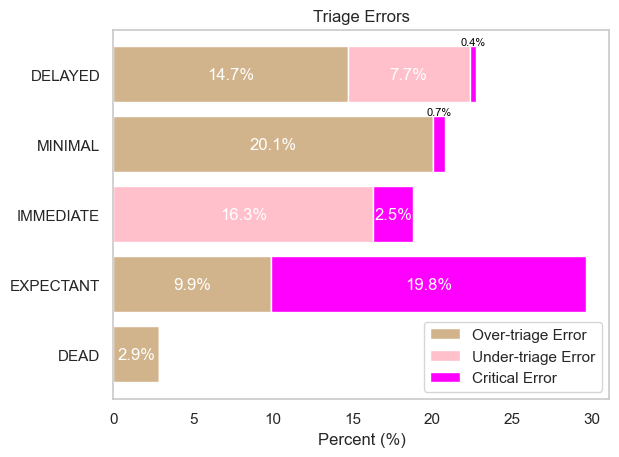

In [21]:

show_stacked_horizontal_bar_chart('max_salt', ylabel='')


### Stacked horizontal bar charts grouped by the last time the patient was tagged

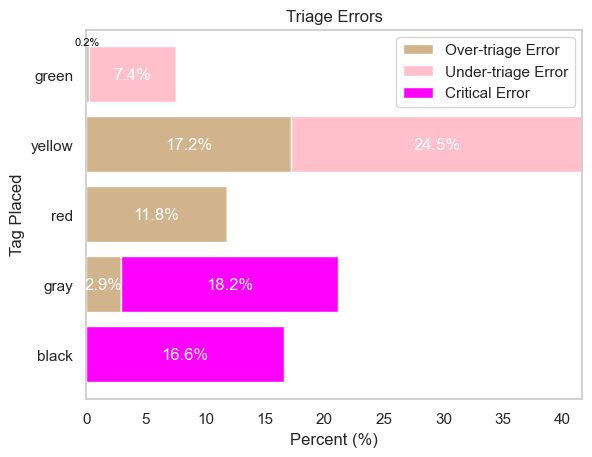

In [22]:

show_stacked_horizontal_bar_chart('last_tag', ylabel='Tag Placed')


# Other Visualizations

## Display some violin plots

In [9]:

def show_violin_plots(column_name, xlabel, title_suffix='Tags', palette=None):
    
    # Sample data for the violin plot
    data = {
        column_name: ERROR_TYPE_DF[column_name].tolist(),
        'patient_count': ERROR_TYPE_DF.patient_count.tolist()
    }
    
    # Create a Data Frame from the data
    df = DataFrame(data)
    
    # Set the style of the plot
    import seaborn as sns
    sns.set(style='whitegrid')
    
    # Create the violin plot with 5 violins
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=column_name, y='patient_count', data=df, palette=palette, inner='stick')
    
    # Set plot labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Patient Count')
    plt.title(f'Distribution of Patients Triaged across different {title_suffix}')
    
    # Show the plot
    plt.show()


### Violin plots grouped by the patient record SALT

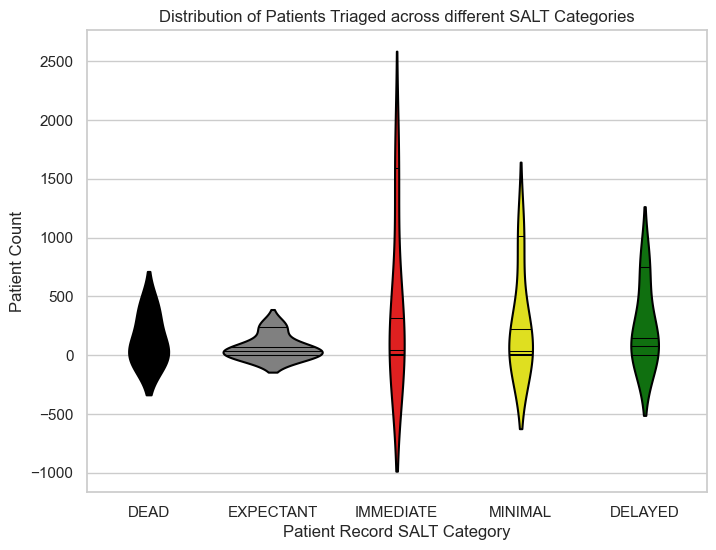

In [10]:

show_violin_plots('max_salt', 'Patient Record SALT Category', title_suffix='SALT Categories', palette=fu.tag_colors)


### Violin plots grouped by the last time the patient was tagged

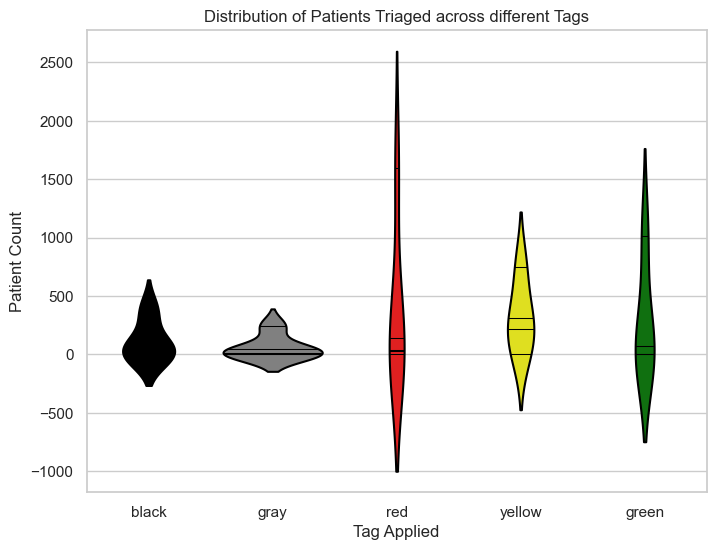

In [11]:

show_violin_plots('last_tag', 'Tag Applied', title_suffix='Tags', palette=fu.tag_colors)


### Violin plots grouped by the triage error

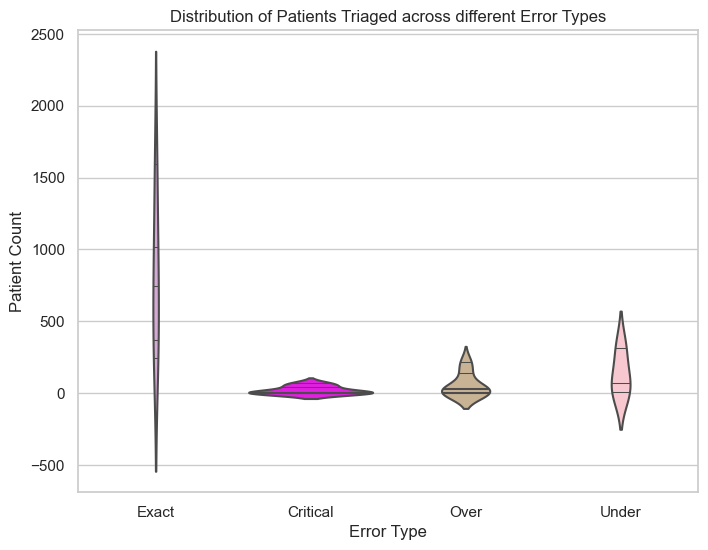

In [12]:

show_violin_plots('error_type', 'Error Type', title_suffix='Error Types', palette=error_colors)


## Display some pie charts

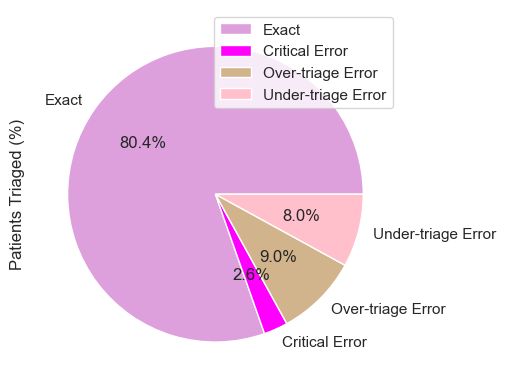

In [13]:

# Display a pie chart of all triaged patients
df = ERROR_TYPE_DF.groupby('error_type').sum().reset_index()
df.error_type = df.error_type
# display(nu.get_statistics(['patient_count'], df).applymap(lambda x: round(x, 1), na_action='ignore').T)
df.plot.pie(
    autopct='%1.1f%%', y='patient_count', ylabel='Patients Triaged (%)', labels=df.error_type.map(suffixing_fn),
    colors=[LABELS_DICT[k] for k in df.error_type]
);

In [14]:

def show_pie_charts(column_name, title_prefix='', suptitle=None):
    
    # Calculate the number of plots and the number of rows and columns
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    num_plots = len(unique_categories)
    num_rows = min(num_plots, 2)
    num_cols = int(np.ceil(num_plots / num_rows))
    
    # Create a figure and subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=False)
    
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        mask_series = (df.patient_count > 0)
        df[mask_series].plot.pie(
            autopct='%1.1f%%', y='patient_count', ylabel='', labels=df[mask_series].error_type.map(suffixing_fn),
            colors=[LABELS_DICT[k] for k in df[mask_series].error_type], ax=axs[i // num_cols, i % num_cols], title=f'{title_prefix}{column_value.title()}'
        );
    
    # Remove the remainder of the plots
    i += 1
    while i < (num_rows * num_cols):
        axs[i // num_cols, i % num_cols].remove()
        i += 1

    if suptitle is not None: fig.suptitle(suptitle)


### Pie charts grouped by the patient record SALT

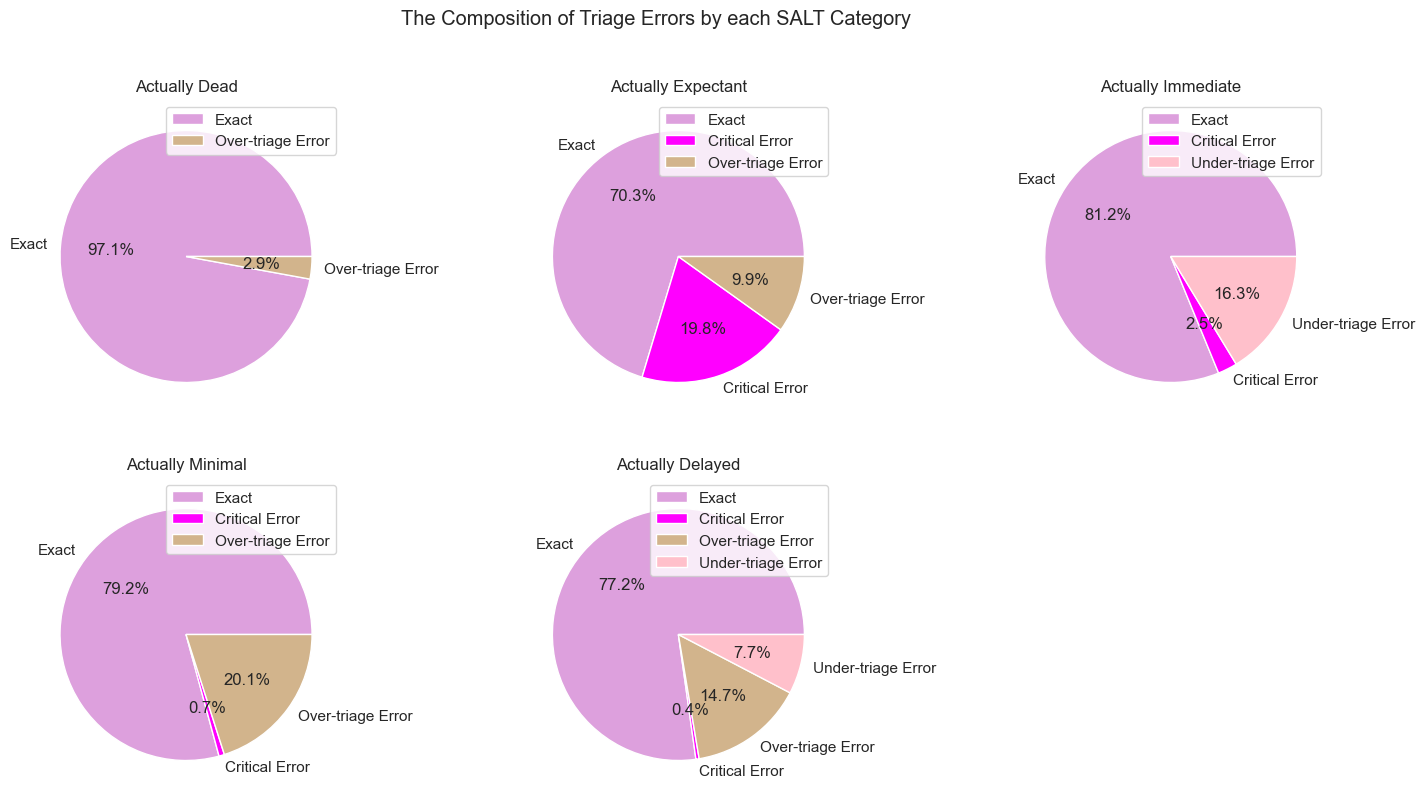

In [15]:

show_pie_charts('max_salt', title_prefix='Actually ', suptitle='The Composition of Triage Errors by each SALT Category')


### Pie charts grouped by the last time the patient was tagged

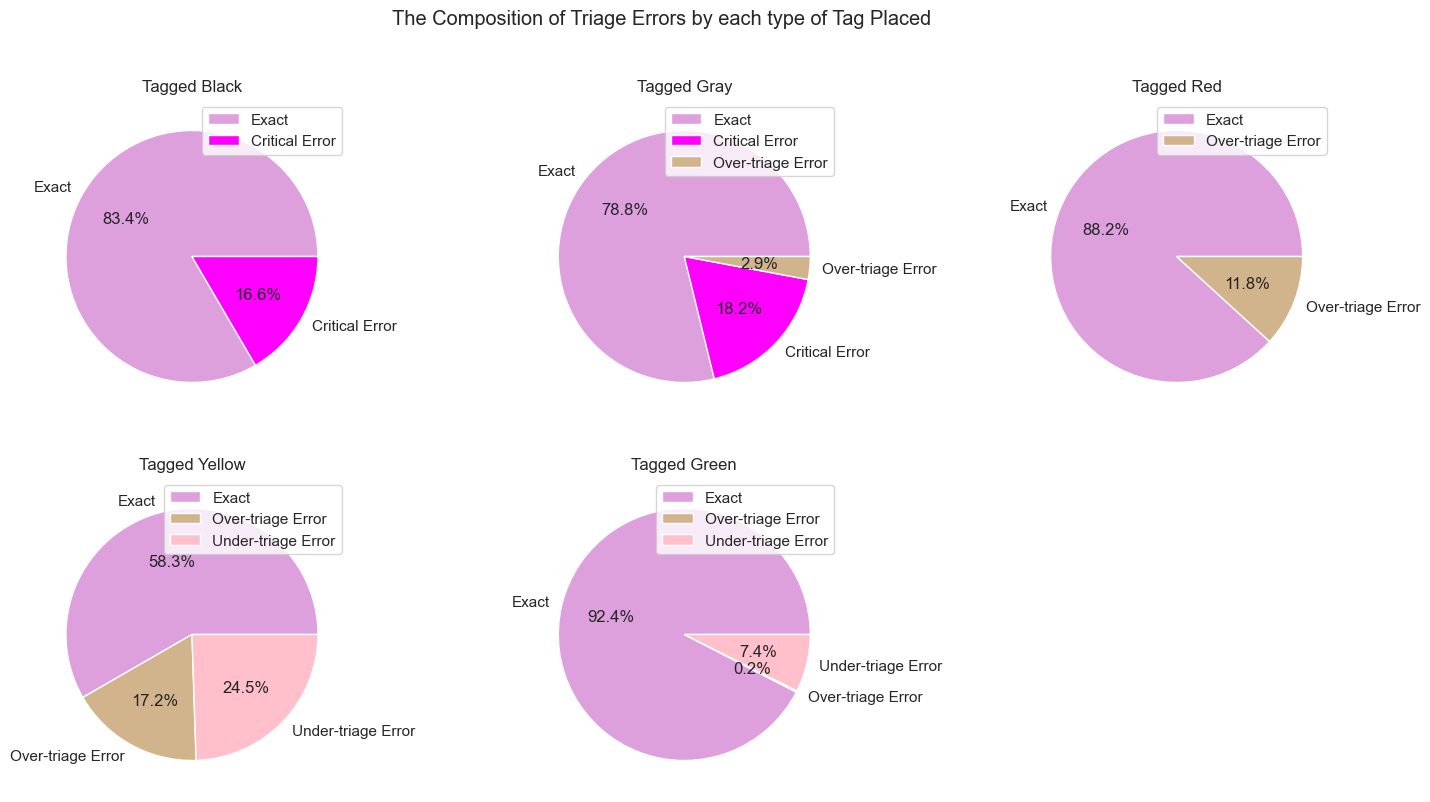

In [16]:

show_pie_charts('last_tag', title_prefix='Tagged ', suptitle='The Composition of Triage Errors by each type of Tag Placed')